Loads data from the dataset and applies transformntions


In [13]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}

# set batch_size
batch_size = 24

# set number of workers
num_workers = 4

train_set = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=data_transforms['testing'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

val_set = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=data_transforms['validation'])
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)                                        
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


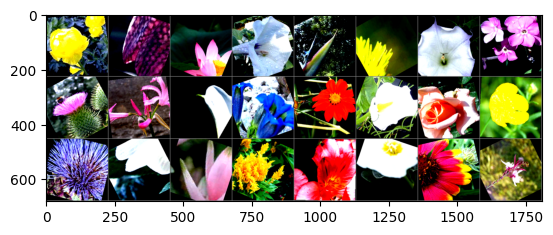

tensor(15)
tensor(22)
tensor(77)
tensor(74)
tensor(7)
tensor(11)
tensor(74)
tensor(31)
tensor(13)
tensor(36)
tensor(19)
tensor(27)
tensor(58)
tensor(19)
tensor(73)
tensor(47)
tensor(28)
tensor(52)
tensor(38)
tensor(26)
tensor(17)
tensor(63)
tensor(99)
tensor(56)


In [2]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
for i in range(batch_size):
  print(labels[i])

In [15]:
class Net(nn.Module):
	
    def __init__(self):
        super(Net, self).__init__()
	# 3 input image channel, 6 output channels, 
	# 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
	# Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 53 * 53, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 110)
        self.fc3 = nn.Linear(110, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=110, bias=True)
  (fc3): Linear(in_features=110, out_features=102, bias=True)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
def testAccuracy(model):
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images.to(device))
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [18]:
from torch.autograd import Variable

def train(epoch_num, model):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        #print("------------------------")
        print("\nepoch: ",epoch,"/",epoch_num)
        #print("------------------------\n")
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        #accuracy = testAccuracy(model)
        #print('EPOCH:', epoch,'---> TEST ACCURACY: %d %%' % (accuracy))
        

    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    print(start.elapsed_time(end))  # milliseconds



In [19]:
def test(model):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [20]:
if __name__ == "__main__":
    
    # train the model with epoch number, model
    train(350, net)
    print('Finished Training')

    # Get the accuracy of the model on the test data
    test(net)
    

The model will be running on cuda:0 device

epoch:  0 / 350

epoch:  1 / 350

epoch:  2 / 350

epoch:  3 / 350

epoch:  4 / 350

epoch:  5 / 350

epoch:  6 / 350

epoch:  7 / 350

epoch:  8 / 350

epoch:  9 / 350

epoch:  10 / 350

epoch:  11 / 350

epoch:  12 / 350

epoch:  13 / 350

epoch:  14 / 350

epoch:  15 / 350

epoch:  16 / 350

epoch:  17 / 350

epoch:  18 / 350

epoch:  19 / 350

epoch:  20 / 350

epoch:  21 / 350

epoch:  22 / 350

epoch:  23 / 350

epoch:  24 / 350

epoch:  25 / 350

epoch:  26 / 350

epoch:  27 / 350

epoch:  28 / 350

epoch:  29 / 350

epoch:  30 / 350

epoch:  31 / 350

epoch:  32 / 350

epoch:  33 / 350

epoch:  34 / 350

epoch:  35 / 350

epoch:  36 / 350

epoch:  37 / 350

epoch:  38 / 350

epoch:  39 / 350

epoch:  40 / 350

epoch:  41 / 350

epoch:  42 / 350

epoch:  43 / 350

epoch:  44 / 350

epoch:  45 / 350

epoch:  46 / 350

epoch:  47 / 350

epoch:  48 / 350

epoch:  49 / 350

epoch:  50 / 350

epoch:  51 / 350

epoch:  52 / 350

epoch:  53 /

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


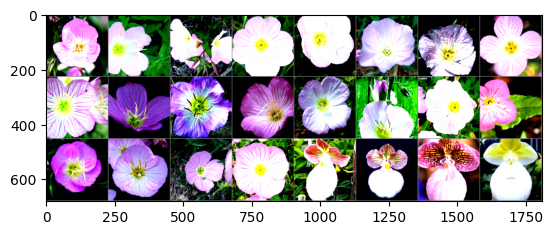

GroundTruth: 
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [42]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ')
for i in range(4):
  print(labels[i])

In [43]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

for i in range(4):
  print(predicted[i])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000232EE832C00>
Traceback (most recent call last):
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rosie\AppData\Local\Programs\Python\Python312\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

The model will be running on cuda:0 device
Accuracy of the network on the 10000 test images: 31 %
